In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

np.random.seed(1)

Outline:
Implement the building block of a convolutional neural network
Convolution functions:
Zero Padding
Convolve window
Convolution Forward
convolution backward (optional)

Pooling functions:
Pooling forward
Create mask
Distribute value
Pooling backward (optional)

In [2]:
def zero_pad(X,pad):
    '''
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of the image, use np.pad function
    '''
    X_pad=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)))

    return X_pad

x.shape= (4, 3, 3, 2)
x_pad.shape= (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


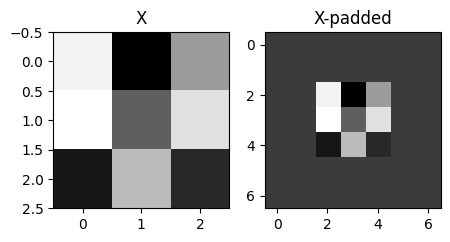

In [3]:
x=np.random.randn(4,3,3,2)
x_pad=zero_pad(x,2)
print('x.shape=',x.shape)
print('x_pad.shape=',x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig,ax=plt.subplots(1,2)
ax[0].set_title('X')
ax[0].imshow(x[0,:,:,0])
ax[1].set_title('X-padded')
ax[1].imshow(x_pad[0,:,:,0])

In [17]:
def conv_single_step(a_slice_prev,W,b):
    '''Perform convolution for one slice or position of a and return a single real value'''
    Z_inter=a_slice_prev*W
    Z_inter=np.sum(Z_inter)
    Z=Z_inter+np.float32(b[0,0,0])
    return Z 

In [37]:
np.random.seed(1)
a_slice_prev=np.random.randn(4,4,3)
W=np.random.randn(4,4,3)
b=np.random.randn(1,1,1)

Z=conv_single_step(a_slice_prev,W,b)
print(f"Z is{format(Z,'.2f')}")

Z is-7.00


In [56]:
def conv_forward(A_prev,W,b,hparameters):
    (m,n_H_prev,n_W_prev,n_C_prev)=A_prev.shape
    (f,f,n_C_prev,n_C)=W.shape
    stride=hparameters['stride']
    padding=hparameters['padding']
    n_H=int(((n_H_prev-f+(2*padding))/stride)+1)
    n_W=int(((n_W_prev-f+(2*padding))/stride)+1)
    Z=np.zeros((m,n_H,n_W,n_C))
    A_prev_pad=np.pad(A_prev,((0,0),(padding,padding),(padding,padding),(0,0)))
    for i in range(m):
        current_a_prev_pad=A_prev_pad[i]
        for ver in range(n_H):
            for hor in range(n_W):
                for channel in range(n_C):
                    vert_start=ver*stride
                    vert_end=vert_start+f
                    horiz_start=hor*stride
                    horiz_end=horiz_start+f
                    a_slice_prev=current_a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    Z[i,ver,hor,channel]=conv_single_step(a_slice_prev,W[:,:,:,channel],b[:,:,:,channel])
    assert(Z.shape==(m,n_H,n_W,n_C))
    cache=(A_prev,W,b,hparameters)
    return Z,cache

In [57]:
np.random.seed(1)
A_prev=np.random.randn(10,4,4,3)
W=np.random.randn(2,2,3,8)
b=np.random.randn(1,1,1,8)
hparameters={'padding':2,
             'stride':2}

Z,cache_conv=conv_forward(A_prev,W,b,hparameters)
print("Z's mean =",np.mean(Z))
print("Z[3,2,1] =", Z[3,:,:,3])

Z's mean = 0.048995203528855794
Z[3,2,1] = [[ 1.1010002   1.1010002   1.1010002   1.1010002 ]
 [ 1.1010002   0.62776531 -0.17734121  1.1010002 ]
 [ 1.1010002   1.75698377  0.63687584  1.1010002 ]
 [ 1.1010002   1.1010002   1.1010002   1.1010002 ]]


In [58]:
def pool_forward(A_prev,hparameters,mode='max'):
    (m,n_H_prev,n_W_prev,n_C_prev)=A_prev.shape
    f=hparameters['pool-f']
    stride=hparameters['pool-stride']

    n_H=int((n_H_prev-f+stride)/stride)
    n_W=int((n_H_prev-f+stride)/stride)
    n_C=n_C_prev

    A=np.zeros((m,n_H,n_W,n_C))

    for i in range(m):
        current_a_prev=A_prev[i]
        for ver in range(n_H):
            for horiz in range(n_W):
                for channel in range(n_C):
                    vert_start=ver*stride
                    vert_end=vert_start+f
                    horiz_start=horiz*stride
                    horiz_end=horiz_start+f

                    a_slice_prev=current_a_prev[vert_start:vert_end,horiz_start:horiz_end,channel]
                    if mode=='average':
                        A[i,ver,horiz,channel]=np.mean(a_slice_prev)
                    else:
                        A[i,ver,horiz,channel]=np.max(a_slice_prev)
    
    assert(A.shape==(m,n_H,n_W,n_C))

    cache=(A_prev,hparameters)
    return A,cache
                

In [60]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"pool-stride" : 2, "pool-f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]
